In [1]:
from datetime import datetime, timedelta
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
!pip install pygeohash
import pygeohash as gh
import torch
from google.cloud import bigquery
from sklearn.metrics.pairwise import haversine_distances
from torch import nn
from sklearn.preprocessing import LabelEncoder
from torch import nn,optim
from datetime import datetime
class BigQueryClient:
    """Wrapper class for BigQuery client"""

    def __init__(self):
        self.client: Optional[bigquery.Client] = None

    def initialize_client(
        self, key_path: Optional[str] = None, project: Optional[str] = None
    ):
        if key_path is not None:
            os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path
        self.client = bigquery.Client(project=project)
        return self

    def query(self, query_string: str) -> pd.DataFrame:
        if self.client is None:
            raise Exception("BigQuery client was not initialized.")
        return self.client.query(query_string).to_dataframe()


bqclient = BigQueryClient().initialize_client()
%reload_ext google.cloud.bigquery

QUERY = """
select user_id,
        request_longitude,request_latitude,request_address,
        op_drop_longitude,op_drop_address,op_drop_latitude,
        pickup_time,drop_time
from {your_company_databasename}.dropoff_home.joined_tb_session where  
        request_longitude is not null and request_latitude is not null and request_address is not null and
        op_drop_longitude is not null and op_drop_address is not null and op_drop_latitude is not null and
        pickup_time is not null  and drop_time is not null
"""
x_interval_minute=5
loc_need_at_least=10
your_company_databasename=" "
QUERY_ = f"""
with tb_od_10 as (
 select distinct(user_id) as user_id from {your_company_databasename}.dropoff_home.joined_tb_session
 group by user_id having count(*)>10 limit 2000
 ),
 tb_drop_5_user as(
 select distinct(op_drop_address) as loc from {your_company_databasename}.dropoff_home.joined_tb_session 
     group by op_drop_address having count(distinct(user_id))>={loc_need_at_least}
 ),
 tb_origin_5_user as(
 select distinct(request_address) as loc from {your_company_databasename}.dropoff_home.joined_tb_session 
     group by request_address having count(distinct(user_id))>={loc_need_at_least}
 )
 select se.user_id,
        se.request_longitude as request_longitudes, se.request_latitude as request_latitudes ,se.request_address as request_addresses,
        se.op_drop_longitude as drop_longitudes ,se.op_drop_address as drop_addresses,se.op_drop_latitude as drop_latitudes,
        se.pickup_time as timestamps_request ,se.drop_time as timestamps_drop from {your_company_databasename}.dropoff_home.joined_tb_session se
    join tb_od_10 on se.user_id=tb_od_10.user_id 
    where se.request_address in (select tb_drop_5_user.loc from tb_drop_5_user
                                 union all
                             select tb_origin_5_user.loc from tb_origin_5_user) 
            and se.op_drop_address in (select tb_drop_5_user.loc from tb_drop_5_user
                                 union all
                             select tb_origin_5_user.loc from tb_origin_5_user)  
            and (se.drop_time - se.pickup_time) > (interval 5 minute)
    order by se.user_id, se.pickup_time
 limit 10000
                            
        
"""

  Using cached pygeohash-1.2.0-py2.py3-none-any.whl
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


data:{
    "key":"user_id":int,
    "value":{
        "train":{
            "request_addresses":List[str],
            "request_latitudes":List[float],
            "request_longitude":List[float],
            "timestamps_request":List[datetime],
            "drop_addresses":List[str],
            "drop_latitude":List[float],
            "drop_longitude":List[float],
            "timestamps_drop":List[datetime],
        },
        "evaluation":{
            "request_addresses":List[str],
            "request_latitudes":List[float],
            "request_longitude":List[float],
            "timestamps_request":List[datetime],
            "drop_addresses":List[str],
            "drop_latitude":List[float],
            "drop_longitude":List[float],
            "timestamps_drop":List[datetime],
        },
        "test":{
            "request_addresses":List[str],
            "request_latitudes":List[float],
            "request_longitude":List[float],
            "timestamps_request":List[datetime],
            "drop_addresses":List[str],
            "drop_latitude":List[float],
            "drop_longitude":List[float],
            "timestamps_drop":List[datetime],
        },
        train on those user having more than 30 trip, use rate 7:2:1 for train,evaluation and test,
        destination in evaluation and test must be in train set
    }
    
    
}

data_preprocessor:{
            "request_addresses":List[str],
            "request_latitudes":List[float],
            "request_longitude":List[float],
            "timestamps_request":List[datetime],
            "drop_addresses":List[str],
            "drop_latitude":List[float],
            "drop_longitude":List[float],
            "timestamps_drop":List[datetime],
        }

In [3]:
def prepare_data_stod_ppa(min_trip_1_user:int=10,max_trip_1_user:int=40) -> Tuple[Dict,Dict]:
    def unsqueeze(input_list:List[List[Any]])->List[Any]:
        ans=[]
        for x in input_list:
            ans.extend(x)
        return ans
    """
        return :data for preprocessor and data for each user
    """
    full_df = bqclient.query(QUERY_)
    all_columns = full_df.columns.tolist()
    all_columns.remove("user_id")
#     data_prepeprocessor={column_name:full_df[column_name].tolist() for column_name in full_df.columns[1:]}
    #     print(all_columns)
    agg_dict = {x: list for x in all_columns}
    agg_dict["count"] = sum

    df_group_user = (
        full_df.assign(count=1).groupby(by=["user_id"]).agg(agg_dict).reset_index()
    )
    df_to_data = (
        df_group_user[((df_group_user["count"]>=min_trip_1_user) &(df_group_user["count"]<=max_trip_1_user))].assign(
            train=lambda df: [
                {x: df.iloc[i][x][: int(0.6 * num)] for x in all_columns}
                for i, num in zip(list(range(len(df))), df["count"].tolist())
            ],
        )
        .assign(
            eval=lambda df: [
                {x: df.iloc[i][x][int(0.6 * num) :int(0.9 * num) ] for x in all_columns}
                for i, num in zip(list(range(len(df))), df["count"].tolist())
            ],
        )
        .assign(
            test=lambda df: [
                {x: df.iloc[i][x][int(0.9 * num) : num] for x in all_columns}
                for i, num in zip(list(range(len(df))), df["count"].tolist())
            ],
        )
        .reset_index(drop=True)
    )
    #     print(all_columns)
    data_preprocessor={
        x:unsqueeze(df_to_data[x].tolist())
        for x in all_columns
    }
    data = {
        df_to_data.iloc[i].user_id: {
            "train": df_to_data.iloc[i].train,
            "eval": df_to_data.iloc[i].eval,
            "test": df_to_data.iloc[i].test,
        }
        for i in range(len(df_to_data))
    }
    return data_preprocessor,data


data_preprocessor,data_users= prepare_data_stod_ppa(10,40)

In [4]:


class Preprocessor:
    def __init__(self):
        self.encoder_location: LabelEncoder = None
        self.encoder_geo_hash: LabelEncoder = None
        self.encoder_timeslot: Callable[[datetime], [int]] = None

        self.od_location: List[Tuple[str, str]] = None
        self.od_coor: List[Tuple[float, float],Tuple[float,float]] = None
        self.od_time: List[Tuple[datetime, datetime]] = None
#         self.od_geohash: List[Tuple[str, str]] = None


        self.L: int = None
        self.G: int = None
        self.T: int = None
        
        self.pairwise_temporal_matrix:np.ndarray
        self.pairwise_spatial_matrix:np.ndarray
        
        self.coor_map_loc_idx:List[Tuple[float,float]]=None

    def timeslot_encoder(
        self, num_slot: int
    ) -> Tuple[int, Callable[[datetime], np.ndarray]]:
        """
        return num_slot,function encode
        """
        assert num_slot > 0 and isinstance(num_slot, int)

        def encode(timestamp: datetime, num_slot=num_slot) -> int:
            time_1_slot = 24.0 / num_slot
            slot = int(timestamp.hour / time_1_slot)
            return slot

        return num_slot, encode

    def geohash_from_latlong(
        self, latitude: float, longitude: float, precision: int
    ) -> str:
        return gh.encode(latitude, longitude, precision)

    
    def create_pairwise_spatial_matrix(self,all_coor:List[Tuple[float,float]]):
        coor=np.radians(all_coor)
        return haversine_distances(coor,coor)
    
    def get_pairwise_spatial(self,loc_idx:int):
        return self.pairwise_spatial_matrix[loc_idx].astype(np.float32)
    
    def create_pairwise_temporal_matrix(self):
        map_loc_idx={x:i for i,x in enumerate(self.encoder_location.classes_)}
        n_loc=self.encoder_location.classes_.shape[0]
        time_diff_matrix=np.full(shape=(n_loc,n_loc),fill_value=0.0)
        count_matrix=np.zeros(shape=time_diff_matrix.shape)
        for od_loc,od_time in zip(self.od_location,self.od_time):
            o_idx=map_loc_idx[od_loc[0]]
            d_idx=map_loc_idx[od_loc[1]]
            timediff=(od_time[1]-od_time[0]).seconds/3600
            
            time_diff_matrix[o_idx,d_idx]+=timediff
            time_diff_matrix[d_idx,o_idx]+=timediff
            
            count_matrix[o_idx,d_idx]+=1
            count_matrix[d_idx,o_idx]+=1
        count_matrix[np.where(count_matrix==0.0)]=1
        return time_diff_matrix/count_matrix
    
    def get_pairwise_temporal(self,loc_idx:int):
        return self.pairwise_temporal_matrix[loc_idx].astype(np.float32)
            
    def fit(
        self,
        request_addresses: List[str],
        drop_addresses: List[str],
        request_latitudes: List[float],
        request_longitudes: List[float],
        drop_latitudes: List[float],
        drop_longitudes: List[float],
        timestamps_request: List[datetime],
        timestamps_drop: List[datetime],
        num_time_slot: int = 8,
    ):

        all_addresses = [*request_addresses, *drop_addresses]

        encoder_location = LabelEncoder()
        encoder_location.fit(all_addresses)
        self.encoder_location=encoder_location
        
        latlong_request = list(
            map(lambda x, y: (x, y), request_latitudes, request_longitudes)
        )
        latlong_drop = list(map(lambda x, y: (x, y), drop_latitudes, drop_longitudes))
        all_latlong = [*latlong_request, *latlong_drop]

        encoded_latlong2geohash = [
            self.geohash_from_latlong(*latlong, precision=5) for latlong in all_latlong
        ]
        encoder_geohash = LabelEncoder()
        encoder_geohash.fit(encoded_latlong2geohash)
        self.encoder_geo_hash=encoder_geohash

        num_timeslot, encoder_timeslot = self.timeslot_encoder(num_slot=num_time_slot)
        self.encoder_timeslot=encoder_timeslot
        
        coor_map_loc_idx=[]
        for i,loc in enumerate(encoder_location.classes_):
            coor_this_loc_idx=all_addresses.index(loc)
            coor_map_loc_idx.append(all_latlong[coor_this_loc_idx])
        
        self.coor_map_loc_idx=coor_map_loc_idx
        
        self.pairwise_spatial_matrix=self.create_pairwise_spatial_matrix(coor_map_loc_idx)
        
        self.od_location=list(zip(request_addresses,drop_addresses))
        self.od_time=list(zip(timestamps_request,timestamps_drop))
        
        self.pairwise_temporal_matrix=self.create_pairwise_temporal_matrix()
        
        self.L=self.encoder_location.classes_.shape[0]
        self.G=self.encoder_geo_hash.classes_.shape[0]
        self.T=num_timeslot


In [5]:
class UsersIdEncoder:
    def __init__(self):
        self.n_users :int
        self.encoder: LabelEncoder = LabelEncoder()
        self.map_user_id_to_encoder_index: Dict = None

    def fit(self, user_id_list: List[int]):
        self.encoder.fit(user_id_list)
        self.n_users=len(self.encoder.classes_)

    def user_id_to_index(self, user_id: int) -> int:
        return self.encoder.transform([user_id]).item()

    def index_to_userid(self, index) -> int:
        return self.encoder.classes_[index]

In [6]:
from abc import ABC
from dataclasses import dataclass


class EncodeRequest:
    pass


@dataclass
class VectorEncodeRequest(EncodeRequest):
    l_location: int
    l_geohash: int
    l_time_slot: int


@dataclass
class LocationEncodeRequest(EncodeRequest):
    location_index: int


class EncodeResponse:
    pass


@dataclass
class VectorEncodeResponse(EncodeResponse):
    vector_l_ti: torch.tensor
    vector_l_geo_ti: torch.tensor
    vector_l_slot_ti: torch.tensor


@dataclass
class LocationEncodeResponse(EncodeResponse):
    vector_l: torch.tensor

In [7]:


class MultiModalEmbbeding(nn.Module):
    """
    w_loc_emdedding,w_geohash_emdedding,w_timeslot_emdedding is separated for every user
    """

    def __init__(
        self,
        location_dim: int,
        geohash_dim: int,
        time_slot_dim: int,
        embedding_dim: int = 256,
    ):
        super(MultiModalEmbbeding, self).__init__()
        self.w_loc_embedding = nn.Embedding(
            num_embeddings=location_dim, embedding_dim=embedding_dim
        )
        self.w_geohash_embedding = nn.Embedding(
            num_embeddings=geohash_dim, embedding_dim=embedding_dim
        )
        self.w_timeslot_embedding = nn.Embedding(
            num_embeddings=time_slot_dim, embedding_dim=embedding_dim
        )

    def forward(self, encode_request: EncodeRequest) -> EncodeResponse:
        if isinstance(encode_request, VectorEncodeRequest):
            l_location = encode_request.l_location
            l_geohash = encode_request.l_geohash
            l_time_slot = encode_request.l_time_slot
            
#             print(l_location,l_geohash,l_time_slot)
            return VectorEncodeResponse(
                self.w_loc_embedding(torch.tensor([l_location])),
                self.w_geohash_embedding(torch.tensor([l_geohash])),
                self.w_timeslot_embedding(torch.tensor([l_time_slot])),
            )

        l_location = encode_request.location_index
        return LocationEncodeResponse(self.w_loc_embedding(torch.tensor([l_location])))

In [8]:
class SpatialEncoder(nn.Module):
    def __init__(self, Ldim: int, dim: int = 256, Hdim: int = 256):
        super().__init__()
        self.W_s_i = nn.Linear(dim, Hdim, bias=False)
        self.W_s_f = nn.Linear(dim, Hdim, bias=False)
        self.W_s_c = nn.Linear(dim, Hdim, bias=False)

        self.V_s_i = nn.Linear(Ldim, Hdim, bias=False)
        self.V_s_f = nn.Linear(Ldim, Hdim, bias=False)
        self.V_s_c = nn.Linear(Ldim, Hdim, bias=False)

        self.U_s_i = nn.Linear(Hdim, Hdim, bias=False)
        self.U_s_f = nn.Linear(Hdim, Hdim, bias=False)
        self.U_s_c = nn.Linear(Hdim, Hdim, bias=False)

        self.b_s_i = nn.Parameter(torch.rand(size=(1, Hdim), requires_grad=True))
        self.b_s_f = nn.Parameter(torch.rand(size=(1, Hdim), requires_grad=True))
        self.b_s_c = nn.Parameter(torch.rand(size=(1, Hdim), requires_grad=True))

        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()

    def forward(
        self,
        vector_l_geo_ti: torch.tensor,
        delta_s_l_ti: torch.tensor,
        h_ti_1: torch.tensor,
        c_s_ti_1: torch.tensor,
    ) -> torch.tensor:
        i_s_ti = self.Sigmoid(
            self.W_s_i(vector_l_geo_ti)
            + self.V_s_i(delta_s_l_ti)
            + self.U_s_i(h_ti_1)
            + self.b_s_i
        )
        f_s_ti = self.Sigmoid(
            self.W_s_f(vector_l_geo_ti)
            + self.V_s_f(delta_s_l_ti)
            + self.U_s_f(h_ti_1)
            + self.b_s_f
        )

        c_tilde_s_ti = self.Tanh(
            self.W_s_c(vector_l_geo_ti)
            + self.V_s_c(delta_s_l_ti)
            + self.U_s_c(h_ti_1)
            + self.b_s_c
        )

        c_s_ti = f_s_ti * c_s_ti_1 + i_s_ti * c_tilde_s_ti
        return c_s_ti


class TemporalEncoder(nn.Module):
    def __init__(self, Ldim: int, dim: int = 256, Hdim: int = 256):
        super().__init__()
    
        self.W_t_i = nn.Linear(dim, Hdim, bias=False)
        self.W_t_f = nn.Linear(dim, Hdim, bias=False)
        self.W_t_c = nn.Linear(dim, Hdim, bias=False)

        self.V_t_i = nn.Linear(Ldim, Hdim, bias=False)
        self.V_t_f = nn.Linear(Ldim, Hdim, bias=False)
        self.V_t_c = nn.Linear(Ldim, Hdim, bias=False)

        self.U_t_i = nn.Linear(Hdim, Hdim, bias=False)
        self.U_t_f = nn.Linear(Hdim, Hdim, bias=False)
        self.U_t_c = nn.Linear(Hdim, Hdim, bias=False)

        self.b_t_i = nn.Parameter(torch.rand(size=(1, Hdim), requires_grad=True))
        self.b_t_f = nn.Parameter(torch.rand(size=(1, Hdim), requires_grad=True))
        self.b_t_c = nn.Parameter(torch.rand(size=(1, Hdim), requires_grad=True))

        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()

    def forward(
        self,
        vector_l_slot_ti: torch.tensor,
        delta_t_l_ti: torch.tensor,
        h_ti_1: torch.tensor,
        c_t_ti_1: torch.tensor,
    ) -> torch.tensor:
        i_t_ti = self.Sigmoid(
            self.W_t_i(vector_l_slot_ti)
            + self.V_t_i(delta_t_l_ti)
            + self.U_t_i(h_ti_1)
            + self.b_t_i
        )
        f_t_ti = self.Sigmoid(
            self.W_t_f(vector_l_slot_ti)
            + self.V_t_f(delta_t_l_ti)
            + self.U_t_f(h_ti_1)
            + self.b_t_f
        )

        c_tilde_t_ti = self.Tanh(
            self.W_t_c(vector_l_slot_ti)
            + self.V_t_c(delta_t_l_ti)
            + self.U_t_c(h_ti_1)
            + self.b_t_c
        )

        c_t_ti = f_t_ti * c_t_ti_1 + i_t_ti * c_tilde_t_ti
#         print("c_t_ti",c_t_ti)
        return c_t_ti


class LSTM(torch.nn.Module):
    def __init__(self, dim: int = 256, Hdim: int = 256):
        """
        dim: dim of loc embedding
        """
        super().__init__()
        self.W_i = nn.Linear(dim, Hdim, bias=False)
        self.W_f = nn.Linear(dim, Hdim, bias=False)
        self.W_o = nn.Linear(dim, Hdim, bias=False)
        self.W_c = nn.Linear(dim, Hdim, bias=False)

        self.U_i = nn.Linear(Hdim, Hdim, bias=False)
        self.U_f = nn.Linear(Hdim, Hdim, bias=False)
        self.U_o = nn.Linear(Hdim, Hdim, bias=False)
        self.U_c = nn.Linear(Hdim, Hdim, bias=False)

        self.b_i = nn.Parameter(torch.rand(size=(1, 1),requires_grad=True))
        self.b_f = nn.Parameter(torch.rand(size=(1, 1),requires_grad=True))
        self.b_o = nn.Parameter(torch.rand(size=(1, 1),requires_grad=True))
        self.b_c = nn.Parameter(torch.rand(size=(1, 1),requires_grad=True))

        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()

    def forward(
        self, x_ti: torch.tensor, c_ti_1: torch.tensor, h_ti_1: torch.tensor
    ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
        i_ti = self.Sigmoid(self.W_i(x_ti) + self.U_i(h_ti_1) + self.b_i)
        f_ti = self.Sigmoid(self.W_f(x_ti) + self.U_f(h_ti_1) + self.b_f)
        o_ti = self.Sigmoid(self.W_o(x_ti) + self.U_o(h_ti_1) + self.b_o)

        c_tilde_ti = self.Tanh(self.W_c(x_ti) + self.U_c(h_ti_1) + self.b_c)

        c_ti = f_ti * c_ti_1 + i_ti * c_tilde_ti

        h_ti = o_ti * self.Tanh(c_ti)
        return o_ti, c_ti, h_ti

In [9]:
class ST_LSTM(nn.Module):
    def __init__(self, Ldim: int, dim: int, Hdim: int):
        super().__init__()
        self.temporal_encoder = TemporalEncoder(Ldim=Ldim, dim=dim, Hdim=Hdim)
        self.lstm = LSTM(dim=dim, Hdim=Hdim)
        self.spatial_encoder = SpatialEncoder(Ldim=Ldim, dim=dim, Hdim=Hdim)
        self.W_h = nn.Linear(3 * Hdim, Hdim)
        self.Tanh = nn.Tanh()

    def forward(
        self,
        c_ti_1: torch.tensor,
        h_ti_1: torch.tensor,
        vector_l_ti: torch.tensor,
        vector_l_geo_ti: torch.tensor,
        vector_l_slot_ti: torch.tensor,
        delta_s_ti: torch.tensor,
        delta_t_l_ti: torch.tensor,
        c_t_ti_1: torch.tensor,
        c_s_ti_1: torch.tensor,
    ):

        o_ti_lstm, c_ti_lstm, h_ti_lstm = self.lstm(vector_l_ti, c_ti_1, h_ti_1)

        c_t_ti = self.temporal_encoder(vector_l_slot_ti, delta_t_l_ti, h_ti_1, c_t_ti_1)
        c_s_ti = self.spatial_encoder(vector_l_geo_ti, delta_s_ti, h_ti_1, c_s_ti_1)

        concated = torch.cat((c_ti_lstm, c_s_ti, c_t_ti), 1)
        tanh_concat= self.Tanh(self.W_h(concated))
        h_ti = o_ti_lstm * tanh_concat
        return (c_ti_lstm, (c_t_ti, c_s_ti)), h_ti

In [10]:
class Encoder(nn.Module):
    st_lstm_o: ST_LSTM
    st_lstm_d: ST_LSTM
    def __init__(self, L: int, G: int, T: int, dim: int = 256, Hdim: int = 256):
        super().__init__()
        self.st_lstm_o = ST_LSTM(Ldim=L, dim=dim, Hdim=Hdim)
        self.st_lstm_d = ST_LSTM(Ldim=L, dim=dim, Hdim=Hdim)
        self.embedding = MultiModalEmbbeding(
            location_dim=L, geohash_dim=G, time_slot_dim=T, embedding_dim=dim
        )
        self.Hdim = Hdim
        self.dim = dim

        self.hidden_states: List[torch.tensor]=[]
            

    def forward(self, preprocessor: Preprocessor,data_this_user:Dict) -> List[torch.tensor]:
        data=data_this_user
        map_location_to_index = {
            x: i for i, x in enumerate(preprocessor.encoder_location.classes_)
        }
        map_geohash_to_index = {
            x: i for i, x in enumerate(preprocessor.encoder_geo_hash.classes_)
        }
        
        s_train_um = list(zip(data["request_addresses"], data["drop_addresses"]))
        
        s_train_o_um = [
            map_location_to_index[x[0]] for x in s_train_um[1:]
        ]
        s_train_d_um = [
            map_location_to_index[x[1]] for x in s_train_um[:-1]
        ]
        
        latlong_request = list(
            map(lambda x, y: (x, y), data["request_latitudes"], data["request_longitudes"])
        )
        latlong_drop = list(map(lambda x, y: (x, y), data["drop_latitudes"], data["drop_longitudes"]))
        all_latlong = [*latlong_request, *latlong_drop]
        
        encoded_latlong2geohash = [
            preprocessor.geohash_from_latlong(*latlong, precision=5) for latlong in all_latlong 
        ]
        n_od = len(s_train_um)
        od_geohash = list(
            zip(encoded_latlong2geohash[:n_od], encoded_latlong2geohash[n_od:])
        )
        s_train_o_geohash = [
            map_geohash_to_index[x[0]] for x in od_geohash[1:]
        ]
        s_train_d_geohash = [
            map_geohash_to_index[x[1]] for x in od_geohash[:-1]
        ]
        
        s_train_time_um = list(zip(data["timestamps_request"], data["timestamps_drop"]))

        s_train_o_timeslot_um = [
            preprocessor.encoder_timeslot(x[0]) for x in s_train_time_um[1:]
        ]
        s_train_d_timeslot_um = [
            preprocessor.encoder_timeslot(x[1]) for x in s_train_time_um[:-1]
        ]


        h_ti, c_ti_lstm, c_t_ti, c_s_ti = (
            torch.rand(size=(1, self.Hdim)),
            torch.rand(size=(1, self.Hdim)),
            torch.rand(size=(1, self.Hdim)),
            torch.rand(size=(1, self.Hdim)),
        )

        h_list_o = []

        for i in range(len(s_train_o_um)):

            o_embedded=self.embedding(
                VectorEncodeRequest(
                    l_location=s_train_o_um[i],
                    l_geohash=s_train_o_geohash[i],
                    l_time_slot=s_train_o_timeslot_um[i]
                )
            )
            vector_l_ti, vector_l_geo_ti, vector_l_slot_ti=o_embedded.vector_l_ti,o_embedded.vector_l_geo_ti,o_embedded.vector_l_slot_ti
            
            loc_index=preprocessor.encoder_location.transform([s_train_um[i][0]]).item()
            
            delta_s_ti_o, delta_t_l_ti_o = preprocessor.get_pairwise_spatial(loc_index),preprocessor.get_pairwise_temporal(loc_index)
            delta_s_ti_o,delta_t_l_ti_o = torch.from_numpy(np.array([delta_s_ti_o])), torch.from_numpy(np.array([delta_t_l_ti_o]))

            (c_ti_lstm, (c_t_ti, c_s_ti)), h_ti = self.st_lstm_o(
                c_ti_lstm,
                h_ti,
                vector_l_ti,
                vector_l_geo_ti,
                vector_l_slot_ti,
                delta_s_ti_o,
                delta_t_l_ti_o,
                c_t_ti,
                c_s_ti,
            )
            
            h_list_o.append(h_ti)
            
        h_ti_d, c_ti_lstm_d, c_t_ti_d, c_s_ti_d = (
            torch.rand(size=(1, self.Hdim)),
            torch.rand(size=(1, self.Hdim)),
            torch.rand(size=(1, self.Hdim)),
            torch.rand(size=(1, self.Hdim)),
        )

        h_list_d = []
        for i in range(len(s_train_d_um)):
            d_embedded=self.embedding(
                VectorEncodeRequest(
                    l_location=s_train_d_um[i],
                    l_geohash=s_train_d_geohash[i],
                    l_time_slot=s_train_d_timeslot_um[i]
                )
            )
            vector_l_ti_d, vector_l_geo_ti_d, vector_l_slot_ti_d=d_embedded.vector_l_ti,d_embedded.vector_l_geo_ti,d_embedded.vector_l_slot_ti
            
            loc_index=preprocessor.encoder_location.transform([s_train_um[i][1]]).item()

            delta_s_ti_d, delta_t_l_ti_d = preprocessor.get_pairwise_spatial(loc_index),preprocessor.get_pairwise_temporal(loc_index)

            delta_s_ti_d, delta_t_l_ti_d = torch.from_numpy(np.array([delta_s_ti_d])), torch.from_numpy(np.array([delta_t_l_ti_d]))
            (c_ti_lstm_d, (c_t_ti_d, c_s_ti_d)), h_ti_d = self.st_lstm_d(
                c_ti_lstm_d,
                h_ti_d,
                vector_l_ti_d,
                vector_l_geo_ti_d,
                vector_l_slot_ti_d,
                delta_s_ti_d,
                delta_t_l_ti_d,
                c_t_ti_d,
                c_s_ti_d,
            )

            h_list_d.append(h_ti_d)
        h_o_d=[*h_list_o, *h_list_d]
        return h_o_d

In [11]:
class Decoder(nn.Module):
    def __init__(self,num_user:int, dim: int = 256, Hdim: int = 256):
        super().__init__()
        self.w_users=nn.Embedding(num_user, dim)
        self.preprocessor: Preprocessor = None
        self.leaky_relu = nn.LeakyReLU(inplace=False)
        self.w_loc: nn.Linear = None
        self.softmax = nn.Softmax(dim=-1)
        self.w_A: nn.Linear = nn.Linear(3 * dim + Hdim, Hdim)
        self.w_loc:nn.Linear
        self.dim=dim
        self.Hdim=Hdim


    def pass_preprocessor(self, prep: Preprocessor):
        self.preprocessor = prep
        self.w_loc=nn.Linear(self.Hdim,self.preprocessor.L)


    def forward(
        self,
        user_id_to_index: int,
        origin: str,
        prev_desination: str,
        hidden_states: List[torch.tensor],
        embedding:nn.Embedding
        
    ) -> Tuple[Union[str, type(None)], int]:
        """
        Return: Tupe[str|Nonetype:output,int:status]
        """
        o_index = self.preprocessor.encoder_location.transform([origin]).item()
        d_prev_index = self.preprocessor.encoder_location.transform([prev_desination]).item()

        with torch.no_grad():
            o_ti_embedded = embedding(LocationEncodeRequest(o_index)).vector_l
            d_ti_1_embedded = embedding(LocationEncodeRequest(d_prev_index)).vector_l

        vector_um = self.w_users(torch.tensor([user_id_to_index]))
        vector_ai_s = []
        for i in range(len(hidden_states)):
            concat_3dim_Hdim = torch.cat(
                (vector_um, o_ti_embedded, d_ti_1_embedded, hidden_states[i]), dim=1
            )
            w_A_concat = self.w_A(concat_3dim_Hdim)
            leaky_w_A_concat = self.leaky_relu(w_A_concat)
            vector_ai_s.append(self.softmax(leaky_w_A_concat))
        ai_dot_hi = torch.cat(
            tuple([ai * hi for ai, hi in zip(vector_ai_s, hidden_states)]), dim=0
        )
        ai_dot_hi_sum = ai_dot_hi.sum(dim=0)
        w_loc_ai_dot_sum=self.w_loc(ai_dot_hi_sum)

        
        output = self.softmax(w_loc_ai_dot_sum)+torch.tensor([1e-10])
        return output, 1

In [12]:


class STOD_PPA(nn.Module):
    
    def __init__(self, dim: int, Hdim: int):
        super().__init__()
        torch.manual_seed(117)
        self.encoder: Encoder
        self.decoder: Decoder 
        self.preprocessor: Preprocessor
#         self.w_loc: nn.Linear
        self.users_id_encoder :UsersIdEncoder
        self.dim = dim
        self.Hdim = Hdim
        self.data_per_user:Dict
        self.optimizer:optim.Adam
        self.train_loss=[]
        self.eval_loss=[]
            
    def fit(self,data_all_user:Dict,data_per_user:Dict,mean_init:float=0,std_init:float=2):
        self.preprocessor=Preprocessor()
        self.preprocessor.fit(**data_all_user)
        self.users_id_encoder=UsersIdEncoder()
        self.users_id_encoder.fit(list(data_per_user.keys()))
        
        self.encoder=Encoder(self.preprocessor.L,self.preprocessor.G,self.preprocessor.T,self.dim,self.Hdim)
        self.decoder=Decoder(self.users_id_encoder.n_users,self.dim,self.Hdim)
        self.data_per_user=data_per_user

        self.decoder.pass_preprocessor(self.preprocessor)
        self.init_weight(mean_init,std_init)

    def init_weight(self,mean:float,std:float):
        for x in self.parameters():
            nn.init.normal_(x,mean,std)
    
    def CE_loss(self, y_h: torch.tensor, y_truth: torch.tensor) -> float:

        ce_loss = nn.CrossEntropyLoss()
        return ce_loss(y_h.view(1, -1), y_truth.view(1))
    
    def eval(self)->float:
        total_loss=0
        for user_idx in range(self.users_id_encoder.n_users):
            data_this_user = self.data_per_user[self.users_id_encoder.index_to_userid(user_idx)]
            data = data_this_user["eval"]
            loss=0
            for i, (origin, prev_des) in enumerate(
                        list(
                            zip(
                                data["request_addresses"][1:],
                                data["drop_addresses"][:-1],
                            )
                        )
                    ):
                        with torch.no_grad():
                            output, status = self.decoder(
                                user_idx, origin, prev_des, self.encoder.hidden_states[user_idx],self.encoder.embedding
                            )
                            loss += self.CE_loss(
                                output,
                                torch.from_numpy(
                                    self.preprocessor.encoder_location.transform(
                                        [data["drop_addresses"][i+1]]
                                    )
                                ),
                            )
            total_loss+=loss/(len(data["request_addresses"])-1)
        return total_loss.item()
                            
    
    def train(self, epochs: int = 15):
        try:
            optimizer=self.optimizer
        except:
            self.optimizer=optim.Adam(
                params=[
                    {"params":self.encoder.parameters(),"lr":0.01},
                    {"params":self.decoder.parameters(),"lr":0.01}
                    
                ],
                lr=1e-2
            )
            optimizer=self.optimizer
        for epoch in range(epochs):
            sum_loss_this_epoch=0
            for user_idx in range(self.users_id_encoder.n_users):
                data_this_user = self.data_per_user[self.users_id_encoder.index_to_userid(user_idx)]
                if user_idx%20==0:
                    print(f"useridx= {user_idx}/{self.users_id_encoder.n_users}, epoch= {epoch} at {datetime.now()}")
                    

                data = data_this_user["train"]

               
                hidden_states: List[torch.tensor] = self.encoder(self.preprocessor,data)
                if epoch==0:
                    self.encoder.hidden_states.append(hidden_states)
                else:
                    self.encoder.hidden_states[user_idx]=hidden_states
                loss=0
                need_backward=False
                for i, (origin, prev_des) in enumerate(
                    list(
                        zip(
                            data["request_addresses"][1:],
                            data["drop_addresses"][:-1],
                        )
                    )
                ):
                    with torch.no_grad():
                        _, status = self.decoder(
                            user_idx, origin, prev_des, hidden_states,self.encoder.embedding
                        )
                    if status == 1: 
                        need_backward=True
                        output, _ = self.decoder(
                            user_idx, origin, prev_des, hidden_states,self.encoder.embedding
                        )
                          

                        loss += self.CE_loss(
                            output,
                            torch.from_numpy(
                                self.preprocessor.encoder_location.transform(
                                    [data["drop_addresses"][i+1]]
                                )
                            ),
                        )
                if need_backward:
                    try:
                        sum_loss_this_epoch+=loss.item()/(len(data["request_addresses"])-1)
                        loss.backward()
                        optimizer.step()
                    
                        optimizer.zero_grad()
                
                    except Exception as e:
                        print(e)
                        pass

            print(f"Total loss this epoch={sum_loss_this_epoch}")
            self.eval_loss.append(self.eval())
            print(f"EVAL LOSS= {self.eval_loss[-1]}")
            self.train_loss.append(sum_loss_this_epoch)
            

    def predict(
        self,
        user_id: int,
        origin: str,
        prev_destination: str,
        request_latitude: float,
        requets_longitude: float,
    ) -> Union[type(None), Tuple[List[str], List[Tuple[float, float]]]]:
        with torch.no_grad():
            user_idx = self.users_id_encoder.user_id_to_index(user_id)

            hiddens_states=self.encoder.hidden_states[user_idx]

            output, status = self.decoder(user_idx, origin, prev_destination,hiddens_states,self.encoder.embedding)
            if status:
                order_idx_loc =output.numpy().argsort()[::-1]

                return (
                    self.preprocessor.encoder_location.inverse_transform(
                        order_idx_loc
                    ),
                    list(
                        map(
                            self.preprocessor.coor_map_loc_idx.__getitem__,
                            order_idx_loc.tolist(),
                        )
                    ),
                )
        return None

In [13]:
len(data_users.keys())

166

In [14]:
net=STOD_PPA(dim=256,Hdim=256)

In [15]:
net.fit(data_preprocessor,data_users,0,1)

In [49]:
net.train(epochs=3)

useridx= 0/166, epoch= 0 at 2022-03-19 12:41:21.257251
useridx= 20/166, epoch= 0 at 2022-03-19 12:41:32.337204
useridx= 40/166, epoch= 0 at 2022-03-19 12:41:42.206215
useridx= 60/166, epoch= 0 at 2022-03-19 12:41:53.845356
useridx= 80/166, epoch= 0 at 2022-03-19 12:42:03.799533
useridx= 100/166, epoch= 0 at 2022-03-19 12:42:16.566466
useridx= 120/166, epoch= 0 at 2022-03-19 12:42:28.859954
useridx= 140/166, epoch= 0 at 2022-03-19 12:42:39.129149
useridx= 160/166, epoch= 0 at 2022-03-19 12:42:53.805402
Total loss this epoch=1290.5119578963624
EVAL LOSS= 1300.561279296875
useridx= 0/166, epoch= 1 at 2022-03-19 12:43:07.698435
useridx= 20/166, epoch= 1 at 2022-03-19 12:43:19.093536
useridx= 40/166, epoch= 1 at 2022-03-19 12:43:29.168270
useridx= 60/166, epoch= 1 at 2022-03-19 12:43:40.936656
useridx= 80/166, epoch= 1 at 2022-03-19 12:43:51.116431
useridx= 100/166, epoch= 1 at 2022-03-19 12:44:04.001064
useridx= 120/166, epoch= 1 at 2022-03-19 12:44:16.406050
useridx= 140/166, epoch= 1 at 

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

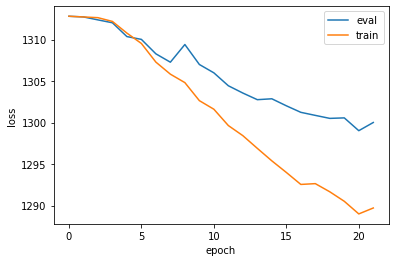

In [50]:
plt.plot(net.eval_loss,label="eval")
plt.plot(net.train_loss,label="train")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [51]:
top=3
count=0
num_test=0
for user_id in data_users.keys():
    test_this_user=data_users[user_id]["eval"]
    for i,(origin,prev_des) in enumerate(
        zip(
            test_this_user["request_addresses"][1:],
            test_this_user["drop_addresses"][:-1]
        )
    ):
        pred_des=net.predict(user_id,origin,prev_des,0,0)[0][:top]
        drop_off=test_this_user["drop_addresses"][i+1] 
        if drop_off in pred_des:
            count+=1
#             print(pred_des)
#             print(drop_off)
        num_test+=1
print(count/num_test)

0.10513739545997611


In [52]:
top=5
count=0
num_test=0
for user_id in data_users.keys():
    test_this_user=data_users[user_id]["test"]
    for i,(origin,prev_des) in enumerate(
        zip(
            test_this_user["request_addresses"][1:],
            test_this_user["drop_addresses"][:-1]
        )
    ):
        pred_des=net.predict(user_id,origin,prev_des,0,0)[0][:top]
        drop_off=test_this_user["drop_addresses"][i+1] 
        if drop_off in pred_des:
            count+=1
#             print(pred_des)
#             print(drop_off)
        num_test+=1
print(count/num_test)

0.10080645161290322
